#  Lab04 Project2        22665473  Zimin Meng

This dataset has 4177 instances and 8 dimensions and one label 'Rings' which is the dimension we would like to predict. A 85/15 random split method is used to performing data and training data set. 'Sex' dimension is encoded therefore can also be used to predict rings. This project using Random Forest Regressor to perform the prediction tasks and using Grid Search to find the best hyperparameters. 

# Data processing and cleaning

In [222]:
#data processing and cleaning
import pandas as pd
raw_data = pd.read_csv('abalone.data', delimiter = ',', header = None)
data_new = raw_data.rename(columns = {0:'Sex', 1:'Length', 2:'Diameter', 3:'Height', 
                                  4:'Whole weight', 5:'Shucked weight', 6:'Viscera weight', 
                                  7:'Shell weight', 8:'Rings'})
data_new = data_new.dropna(axis = 0) 
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 326.3+ KB


In [223]:
#Encoded Sex from category to numeric
from sklearn.preprocessing import OrdinalEncoder
sex_col = data_new[['Sex']]
ordinal_encoder = OrdinalEncoder()
sex_encoded = ordinal_encoder.fit_transform(sex_col)
sex_encoded

array([[2.],
       [2.],
       [0.],
       ...,
       [2.],
       [0.],
       [2.]])

In [224]:
data_new['Sex'] = sex_encoded
data_new.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,2.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,2.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,1.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [225]:
#Splitting the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

train, test = train_test_split(data_new, test_size = 0.15 , random_state = 42)

class_set = []
new_set = []
def split_label(data_set):
    class_set = data_set['Rings']
    new_set = data_set.drop('Rings', axis = 1)
    
    return new_set, class_set
            
train_x_raw, train_y = split_label(train)
test_x_raw, test_y = split_label(test)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_x_raw.astype(np.float64))
test_scaled = scaler.transform(test_x_raw.astype(np.float64))

In [226]:
#convert to new dataset 
import pandas as pd

def convert_fn(dataset):
    scaled_data = pd.DataFrame(dataset)
    scaled_data = scaled_data.rename(columns = {0:'Sex', 1:'Length', 2:'Diameter', 3:'Height', 
                                            4:'Whole weight', 5:'Shucked weight', 6:'Viscera weight', 
                                            7:'Shell weight'})
    return scaled_data

train_x = convert_fn(train_scaled)
test_x = convert_fn(test_scaled)

# Running Regressor

Using GridSearchCV method to find the best parameters for the model and from the result showing above, we could see when n_estimator is 500 and max_depth is 4 the model performs best. Therefore we choosing these two values as our hyperparameters.
The model has all the dimensions of the data set which has MSE of 5.215 for testing data set, 4.729 for training set. 

In [227]:
#Running Random Forest Regressor
#Searching for best estimators used for regressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = ({
    'n_estimators' : [10,100,500], 'max_depth' :[1,4]
})


forest_reg = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True) 

grid_search.fit(train_scaled, train_y)

grid_search.best_params_


{'max_depth': 4, 'n_estimators': 500}

In [236]:
#Reporting MSE for both set 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
best_forest_reg = RandomForestRegressor(max_depth = 4, n_estimators = 500, random_state = 42)

def cal_mse(reg, train_x, train_y, test_x, test_y):
    reg.fit(train_x, train_y)
    pred_y_test = np.round(reg.predict(test_x))
    pred_y_train = np.round(reg.predict(train_x))
    mse_test = mean_squared_error(test_y, pred_y_test)
    mse_train = mean_squared_error(train_y, pred_y_train)
    return pred_y_test,pred_y_train, mse_test, mse_train

pred_test, pred_train, mse_test, mse_train, = cal_mse(best_forest_reg, train_x, train_y, test_x, test_y)
print('The original dataset has %d dimensions, the MSE for testing set is %.3f, the MSE for training set is %.3f.' 
      %(train_x.shape[1], mse_test, mse_train))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


The original dataset has 8 dimensions, the MSE for testing set is 5.215, the MSE for training set is 4.729.


In [229]:
import numpy as np
pred_train.reshape(-1,1)
pred_test = np.array(pred_test).reshape(-1,1)
test_y = np.array(test_y).reshape(-1,1)
train_y = np.array(train_y).reshape(-1,1)

In [230]:
import numpy as np

test_error = []
sum_error_test = []
train_error = []
sum_error_train = []
for i in range(0,len(pred_test)):
    test_error.append(pred_test[i] - test_y[i])
    sum_error_test = np.sum(test_error)
print("The raw error for test set is : ",sum_error_test)

for i in range(0,len(pred_train)):
    train_error.append(pred_train[i] - train_y[i])
    sum_error_train = np.sum(train_error)
print("The raw error for train set is : ",sum_error_train)

The raw error for test set is :  -60.0
The raw error for train set is :  -86.0


# New model after reduce the dimensions 

From the below the result of feature importances we choosing 'Shell weight' which counts for 82.92%, 'Shucked weight' which counts for 12.49% and 'Diameter' counts for 1.84% as the featured dimensions and rerun the randomforest regressor.
The new model has 3 dimensions, the MSE for testing set is 5.335, the MSE for training set is 4.839.
The raw error for test set is -45.0 and is0 for train set.

In [231]:
#Compare feature importance
feature = []
for name, score in zip(train_x, best_forest_reg.feature_importances_):
    feature.append((score, name))
    
feature.sort(reverse = True)
feature

[(0.8292487151728267, 'Shell weight'),
 (0.12490063674117265, 'Shucked weight'),
 (0.018445774895707024, 'Diameter'),
 (0.010931736924709307, 'Sex'),
 (0.005562264715811438, 'Whole weight'),
 (0.004512903787263986, 'Height'),
 (0.003340744545065061, 'Length'),
 (0.0030572232174437067, 'Viscera weight')]

In [232]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
new_train_x = pd.DataFrame(train_x, columns = ['Shell weight','Shucked weight','Diameter'])
new_test_x = pd.DataFrame(test_x, columns = ['Shell weight','Shucked weight','Diameter'])

scaler = StandardScaler()
new_train_x = scaler.fit_transform(new_train_x.astype(np.float64))
new_test_x = scaler.transform(new_test_x.astype(np.float64))

In [237]:
pred_test_2, pred_train_2, mse_test_2, mse_train_2, = cal_mse(best_forest_reg, new_train_x, train_y, new_test_x , test_y)
print('The original dataset has %d dimensions, the MSE for testing set is %.3f, the MSE for training set is %.3f.' 
      %(new_train_x.shape[1], mse_test_2, mse_train_2))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


The original dataset has 3 dimensions, the MSE for testing set is 5.335, the MSE for training set is 4.839.


In [234]:
import numpy as np
pred_train_2 = np.array(pred_train_2).reshape(-1,1)
test_error2 = []
sum_error_test2 = []
train_error2 = []
sum_error_train2 = []
for i in range(0,len(pred_test_2)):
    test_error2.append(pred_test_2[i] - test_y[i])
    sum_error_test2 = np.sum(test_error2)
print("The raw error for test set is : ",sum_error_test2)

for i in range(0,len(pred_train_2)):
    train_error.append(pred_train_2[i] - train_y[i])
    sum_error_train2 = np.sum(train_error2)
print("The raw error for train set is : ",sum_error_train2)

The raw error for test set is :  -45.0
The raw error for train set is :  0.0


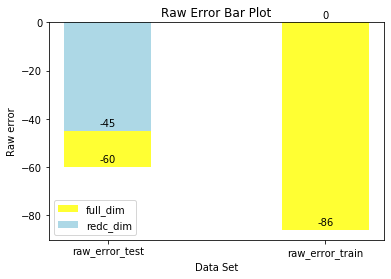

In [235]:
#Plotting Raw Error for both regressors on training and testing set
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd

label_list = ['raw_error_test','raw_error_train'] 
reg1 = [-60, -86]
reg2 = [-45, 0]
x = range(len(reg1))

rects1 = plt.bar(x, height=reg1, width=0.4, alpha = 0.8, color = 'yellow', label="full_dim")
rects2 = plt.bar(x, height=reg2, width=0.4, color = 'lightblue', label="redc_dim")
plt.xticks(x, label_list)
plt.xlabel('Data Set')
plt.title("Raw Error Bar Plot")
plt.ylabel('Raw error')
plt.legend()
for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")

plt.show()

Generally speaking, by comparing the MSE and raw error for two regressor we find that reducing the dimensions is no necessary to improve the performance of regressors since the MSE for testing set of regressor 2 is even higher than regressor 1. However from the raw error plot above, we still can see that the raw error for regressors with full dimension is higher than the regressor with reducted dimensions. Regressor2 incidently has raw error of 0 on  training set, but it's just a conincidence.